# Bowl Glory vs Fight Song Heat
Using `fight_songs.csv` (FiveThirtyEight) + `bowl_games.csv` (Kaggle) to see whether bowl dominance lines up with how hyped the fight songs feel. Big Ten schools are outlined/highlighted throughout.

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, colors
from matplotlib import patheffects
import plotly.express as px
import plotly.graph_objects as go

# Dark, high-contrast base
plt.rcParams.update({
    "figure.facecolor": "#0b0f1d",
    "axes.facecolor": "#0b0f1d",
    "axes.edgecolor": "#20253a",
    "axes.labelcolor": "#e8ecff",
    "text.color": "#e8ecff",
    "xtick.color": "#cfd3ff",
    "ytick.color": "#cfd3ff",
    "axes.titleweight": "bold",
    "axes.titlepad": 18,
    "grid.color": "#20253a",
    "font.size": 12,
    "savefig.facecolor": "#0b0f1d",
})

sns.set_theme(style="white")
# Accent colors
pulse = "#f1605d"
teal = "#5ad1f0"


In [2]:


CURRENT_YEAR = 2025
name_map = {
    "Louisiana State": "LSU",
    "Pittsburgh": "Pitt",
    "Southern California": "USC",
    "Texas Christian": "TCU",
}

fight = pd.read_csv("fight_songs.csv")
bowl = pd.read_csv("bowl_games.csv")

# Ensure year values are numeric so age math works even with unknowns
fight["year"] = pd.to_numeric(fight["year"], errors="coerce")

# Standardize names for joining
bowl["winner_std"] = bowl["winner_tie"].replace(name_map)
bowl["loser_std"] = bowl["loser_tie"].replace(name_map)

long = bowl.melt(id_vars="year", value_vars=["winner_std", "loser_std"], value_name="school")
appearances = long.groupby("school").size()
wins = bowl["winner_std"].value_counts()
first_years = long.groupby("school")["year"].min()

bowl_stats = (
    pd.DataFrame({
        "bowl_appearances": appearances,
        "bowl_wins": wins,
        "first_bowl_year": first_years,
    })
    .fillna(0)
    .astype({"bowl_appearances": int, "bowl_wins": int, "first_bowl_year": int})
)
bowl_stats = bowl_stats.reset_index().rename(columns={"index": "school"})
bowl_stats["bowl_win_rate"] = np.where(
    bowl_stats["bowl_appearances"] > 0,
    bowl_stats["bowl_wins"] / bowl_stats["bowl_appearances"],
    np.nan,
)

hype_flags = ["fight", "victory", "rah", "nonsense", "colors", "men", "opponents"]
yn_map = {"yes": 1, "y": 1, "true": 1, "1": 1, "no": 0, "n": 0, "false": 0, "0": 0}
for col in hype_flags:
    fight[col] = fight[col].apply(lambda v: yn_map.get(str(v).strip().lower(), 0))

fight["song_age"] = CURRENT_YEAR - fight["year"]
fight["lyric_heat"] = fight[hype_flags].sum(axis=1)

for col in ["bpm", "trope_count", "sec_duration"]:
    fight[f"z_{col}"] = (fight[col] - fight[col].mean()) / fight[col].std(ddof=0)

fight["hype_score"] = fight[["z_bpm", "z_trope_count", "z_sec_duration"]].sum(axis=1) + 0.6 * fight["lyric_heat"]

viz = fight.merge(bowl_stats, on="school", how="left")
viz = viz.sort_values("bowl_wins", ascending=False)
viz["is_big_ten"] = viz["conference"].eq("Big Ten")

print("Schools in both datasets:", len(viz))
display_cols = [
    "school",
    "conference",
    "bowl_appearances",
    "bowl_wins",
    "bowl_win_rate",
    "bpm",
    "trope_count",
    "song_age",
    "hype_score",
]
viz[display_cols].head()


Schools in both datasets: 65


,school,conference,bowl_appearances,bowl_wins,bowl_win_rate,bpm,trope_count,song_age,hype_score
37,Alabama,SEC,75,45,0.600000,153,6,99.0,4.651906
41,Georgia,SEC,59,37,0.627119,162,1,110.0,-1.808267
33,USC,Pac-12,55,35,0.636364,75,5,103.0,0.519111
7,Texas,Big 12,57,33,0.578947,81,4,102.0,0.300651
21,Penn State,Big Ten,51,32,0.627451,145,5,92.0,3.491631


/var/folders/cf/zn4dq46s1rx6x1s67d5x5v440000gn/T/ipykernel_52744/1307766486.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_heat = cm.get_cmap("plasma")
/var/folders/cf/zn4dq46s1rx6x1s67d5x5v440000gn/T/ipykernel_52744/1307766486.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_age = cm.get_cmap("cividis")


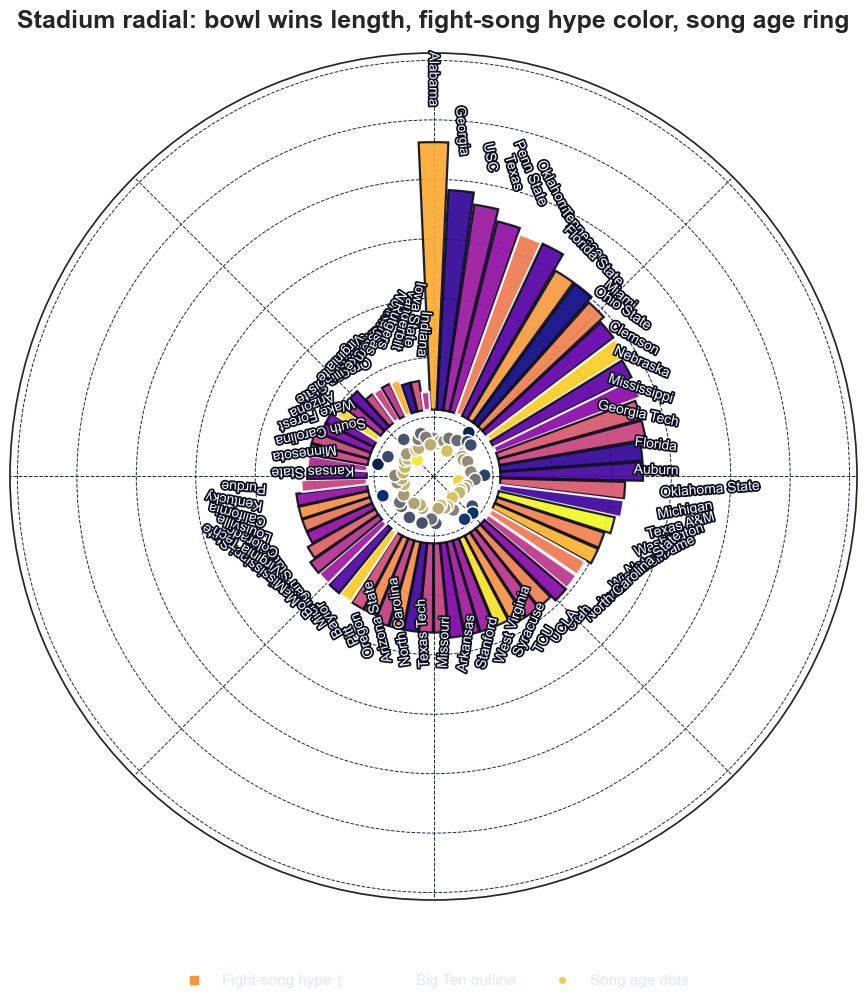

In [3]:

# Hero viz: stadium-style polar bars
stadium = viz.reset_index(drop=True)
angles = np.linspace(0, 2 * np.pi, len(stadium), endpoint=False)
width = 2 * np.pi / len(stadium) * 0.92

hype_norm = colors.Normalize(stadium["hype_score"].min(), stadium["hype_score"].max())
age_norm = colors.Normalize(stadium["song_age"].min(), stadium["song_age"].max())
cmap_heat = cm.get_cmap("plasma")
cmap_age = cm.get_cmap("cividis")
bar_colors = cmap_heat(hype_norm(stadium["hype_score"]))

base = stadium["bowl_wins"].max() * 0.25

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw={"projection": "polar"})
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.grid(color="#20253a", linestyle="--", linewidth=0.7)

edge_colors = ["#fafafa" if bt else "#0b0f1d" for bt in stadium["is_big_ten"]]

ax.bar(
    angles,
    stadium["bowl_wins"],
    width=width,
    bottom=base,
    color=bar_colors,
    edgecolor=edge_colors,
    linewidth=1.6,
    alpha=0.92,
)

age_r = base * (0.35 + 0.5 * (1 - age_norm(stadium["song_age"])))
ax.scatter(
    angles,
    age_r,
    c=cmap_age(age_norm(stadium["song_age"])),
    s=90,
    edgecolors="white",
    linewidth=1.2,
    zorder=5,
)

for theta, row in zip(angles, stadium.itertuples()):
    rot = np.degrees(theta)
    ha = "left" if np.pi / 2 <= theta <= 3 * np.pi / 2 else "right"
    ax.text(
        theta,
        base + row.bowl_wins + 6,
        row.school,
        rotation=rot - 90,
        rotation_mode="anchor",
        ha=ha,
        va="center",
        fontsize=10,
        color="#f5f6ff",
        path_effects=[patheffects.withStroke(linewidth=2.5, foreground="#0b0f1d")],
    )

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_ylim(0, base + stadium["bowl_wins"].max() + 15)

legend_items = [
    plt.Line2D([0], [0], marker="s", linestyle="", color=cmap_heat(0.75), label="Fight-song hype ↑"),
    plt.Line2D([0], [0], marker="s", linestyle="", markerfacecolor="none", markeredgecolor="white", markersize=12, label="Big Ten outline"),
    plt.Line2D([0], [0], marker="o", linestyle="", color=cmap_age(0.9), markeredgecolor="white", label="Song age dots"),
]
ax.legend(
    handles=legend_items,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=False,
    labelcolor="#dfe6ff",
)

ax.set_title("Stadium radial: bowl wins length, fight-song hype color, song age ring", fontsize=18)
plt.show()


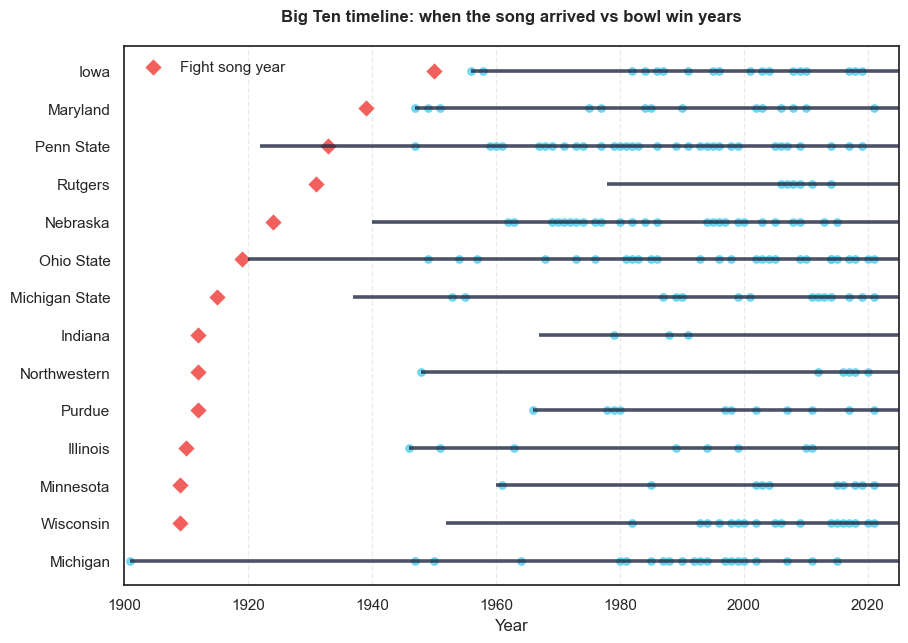

In [4]:

# Big Ten timeline: fight song debut vs bowl win years
big_ten = viz[viz["is_big_ten"]].copy()
win_years = bowl[bowl["winner_std"].isin(big_ten["school"])]
win_years = win_years.groupby("winner_std")["year"].apply(list).to_dict()

fig, ax = plt.subplots(figsize=(10, 7))
y_pos = np.arange(len(big_ten))
ordered = big_ten.sort_values("song_age", ascending=False)

for y, row in enumerate(ordered.itertuples()):
    years = win_years.get(row.school, [])
    if years:
        ax.scatter(years, [y] * len(years), color=teal, s=28, alpha=0.8)
    ax.scatter([row.year], [y], color=pulse, marker="D", s=90, edgecolor="white", linewidth=1.2, label="Fight song year" if y == 0 else "")
    ax.hlines(y, row.first_bowl_year, 2025, color="#1f2840", linewidth=2.6, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(ordered["school"])
ax.set_xlim(1900, 2025)
ax.set_xlabel("Year")
ax.set_title("Big Ten timeline: when the song arrived vs bowl win years")
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.legend(frameon=False, loc="upper left")
plt.show()


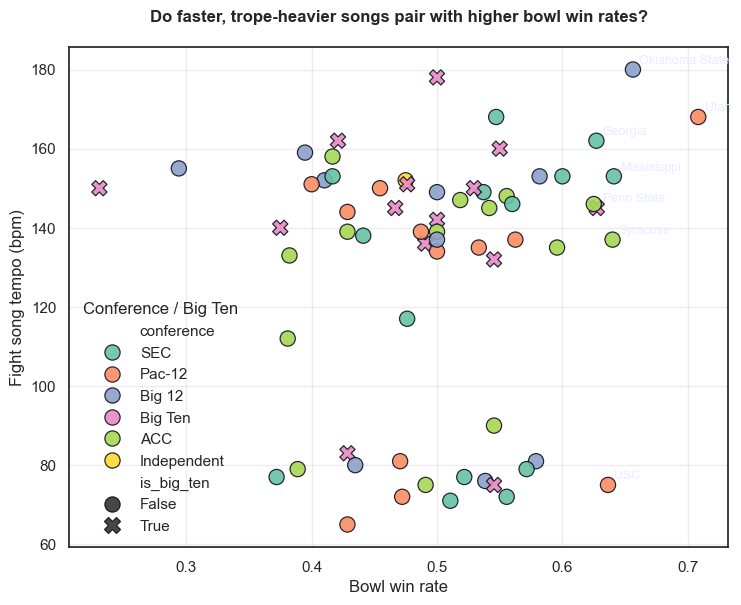

In [5]:

# Win rate vs tempo
fig, ax = plt.subplots(figsize=(8.5, 6.5))
sns.scatterplot(
    data=viz,
    x="bowl_win_rate",
    y="bpm",
    hue="conference",
    style="is_big_ten",
    palette="Set2",
    s=120,
    edgecolor="#0b0f1d",
    alpha=0.9,
    ax=ax,
)

for row in viz.nlargest(7, "bowl_win_rate").itertuples():
    ax.text(row.bowl_win_rate + 0.005, row.bpm + 1.5, row.school, fontsize=9, color="#e8ecff")

ax.set_xlabel("Bowl win rate")
ax.set_ylabel("Fight song tempo (bpm)")
ax.set_title("Do faster, trope-heavier songs pair with higher bowl win rates?")
ax.grid(alpha=0.35)
ax.legend(title="Conference / Big Ten", frameon=False)
plt.show()


## Interactive, readable views
Hover for details, and tweak `top_n` in the cells if you want more or fewer schools in the polar view.

In [6]:

# Interactive polar stadium (top_n keeps text manageable)
top_n = 40
stadium = viz.sort_values("bowl_wins", ascending=False).head(top_n).reset_index(drop=True)
stadium["theta_deg"] = np.linspace(0, 360, len(stadium), endpoint=False)

fig = px.bar_polar(
    stadium,
    r="bowl_wins",
    theta="theta_deg",
    color="hype_score",
    color_continuous_scale="Plasma",
    hover_name="school",
    hover_data={
        "bowl_appearances": True,
        "bowl_wins": True,
        "bowl_win_rate": ":.2f",
        "song_age": ":.0f",
        "bpm": True,
        "trope_count": True,
        "conference": True,
        "is_big_ten": True,
    },
)
fig.update_traces(
    marker_line_color=np.where(stadium["is_big_ten"], "#f5f6ff", "#0b0f1d"),
    marker_line_width=np.where(stadium["is_big_ten"], 2.2, 0.8),
    opacity=0.9,
)
fig.update_layout(
    template="plotly_dark",
    title=f"Interactive stadium: top {top_n} bowl winners (color = hype, outline = Big Ten)",
    polar=dict(
        radialaxis=dict(showticklabels=True, ticks="", linewidth=1, gridcolor="#2c314c"),
        angularaxis=dict(showticklabels=False, ticks="", rotation=90, direction="clockwise"),
        bgcolor="#0b0f1d",
    ),
    coloraxis_colorbar=dict(title="Hype score"),
    margin=dict(l=30, r=30, t=70, b=30),
)
fig.show()


In [7]:

# Horizontal bar for quick readability (top 30 by bowl wins)
top_bar = viz.nlargest(30, "bowl_wins").sort_values("bowl_wins")
fig = px.bar(
    top_bar,
    x="bowl_wins",
    y="school",
    color="hype_score",
    color_continuous_scale="Plasma",
    orientation="h",
    hover_data={
        "bowl_appearances": True,
        "bowl_wins": True,
        "bowl_win_rate": ":.2f",
        "song_age": ":.0f",
        "bpm": True,
        "trope_count": True,
        "conference": True,
        "is_big_ten": True,
    },
    labels={"bowl_wins": "Bowl wins", "school": "School"},
)
fig.update_traces(
    marker_line_color=np.where(top_bar["is_big_ten"], "#f5f6ff", "#0b0f1d"),
    marker_line_width=np.where(top_bar["is_big_ten"], 2.2, 0.6),
)
fig.update_layout(
    template="plotly_dark",
    title="Top 30 bowl winners (color = hype score, outline = Big Ten)",
    height=800,
    margin=dict(l=40, r=20, t=70, b=40),
)
fig.show()


In [8]:

# Big Ten timeline: interactive version
big_ten = viz[viz["is_big_ten"]].copy()
win_years = bowl[bowl["winner_std"].isin(big_ten["school"])]
rows = []
for school, grp in win_years.groupby("winner_std"):
    for year in grp["year"]:
        rows.append({"school": school, "year": year, "event": "Bowl win"})
for row in big_ten.itertuples():
    rows.append({"school": row.school, "year": row.year, "event": "Fight song debut"})

timeline = pd.DataFrame(rows)
order = big_ten.sort_values("song_age", ascending=False)["school"]
fig = px.scatter(
    timeline,
    x="year",
    y="school",
    color="event",
    symbol="event",
    color_discrete_map={"Fight song debut": "#f1605d", "Bowl win": "#5ad1f0"},
    hover_data={"year": True, "school": False},
)
fig.update_yaxes(categoryorder="array", categoryarray=list(order))
fig.update_layout(
    template="plotly_dark",
    title="Big Ten timeline: fight song debut vs bowl win years",
    height=650,
    xaxis=dict(range=[1900, CURRENT_YEAR + 1], dtick=10, showgrid=True, gridcolor="#2c314c"),
    margin=dict(l=70, r=20, t=70, b=40),
)
fig.show()


In [9]:

# Interactive win rate vs tempo
fig = px.scatter(
    viz,
    x="bowl_win_rate",
    y="bpm",
    size="trope_count",
    color="hype_score",
    symbol="is_big_ten",
    hover_name="school",
    color_continuous_scale="Plasma",
    labels={"is_big_ten": "Big Ten", "bowl_win_rate": "Bowl win rate", "bpm": "Tempo (bpm)", "trope_count": "Trope count"},
)
fig.update_layout(
    template="plotly_dark",
    title="Win rate vs tempo (size = tropes, color = hype)",
    height=600,
    margin=dict(l=40, r=20, t=70, b=40),
)
fig.show()


## Chapter 1 – Where does hype live?
Interactive US map: dot size = bowl success, color = hype. Use the buttons or legend to filter conferences.


In [ ]:

# Geo lookup (cached) for school locations
# Requires geopy (install with `pip install geopy` if missing)
import os
try:
    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter
except ImportError:
    raise ImportError("Install geopy to render the map: pip install geopy")

cache_path = "school_geo_cache.csv"
geo_cache = None
if os.path.exists(cache_path):
    geo_cache = pd.read_csv(cache_path)
else:
    geo_cache = pd.DataFrame(columns=["school", "lat", "lon"])

missing = sorted(set(viz["school"]) - set(geo_cache["school"]))
if missing:
    geolocator = Nominatim(user_agent="fight-song-map")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    new_rows = []
    for school in missing:
        loc = geocode(f"{school} University") or geocode(f"{school} College") or geocode(school)
        if loc:
            new_rows.append({"school": school, "lat": loc.latitude, "lon": loc.longitude})
    if new_rows:
        geo_cache = pd.concat([geo_cache, pd.DataFrame(new_rows)], ignore_index=True)
        geo_cache.to_csv(cache_path, index=False)

viz_geo = viz.merge(geo_cache, on="school", how="left")
map_df = viz_geo.dropna(subset=["lat", "lon"])
print(f"Geocoded schools: {len(map_df)}/{len(viz)}")


In [ ]:

# Hero viz: interactive US map
if map_df.empty:
    raise ValueError("No geocoded schools available. Run the cell above to populate the cache.")

size_metric = map_df["bowl_win_rate"].fillna(0) * map_df["bowl_appearances"].clip(lower=1)
fig = px.scatter_geo(
    map_df,
    lat="lat",
    lon="lon",
    color="hype_score",
    size=size_metric,
    scope="usa",
    hover_name="school",
    hover_data={
        "conference": True,
        "song_name": True if "song_name" in map_df.columns else False,
        "bpm": True,
        "year": True,
        "bowl_appearances": True,
        "bowl_wins": True,
        "bowl_win_rate": ":.2f",
    },
    color_continuous_scale="Plasma",
    projection="albers usa",
)

buttons = [
    dict(label="All", method="update", args=[{"visible": [True] * len(fig.data)}, {"title": "All conferences"}])
]
confs = list(map_df["conference"].dropna().unique())
for conf in confs:
    visible = [trace.name == conf for trace in fig.data]
    buttons.append(dict(label=conf, method="update", args=[{"visible": visible}, {"title": conf}]))

fig.update_layout(
    title="Where hype lives: map sized by bowl success, colored by hype score",
    template="plotly_dark",
    margin=dict(l=0, r=0, t=50, b=0),
    geo=dict(bgcolor="#0b0f1d"),
    updatemenus=[dict(type="buttons", buttons=buttons, direction="right", x=0, y=1.12, showactive=True)],
    legend_title="Conference",
)
fig.show()


## Chapter 2 – Does hype translate to trophies?
Scatter: tempo vs bowl win rate. Color by conference; shape for Big Ten. Outliers annotated.


In [ ]:

# Hero viz: interactive scatter
fig = px.scatter(
    viz,
    x="bowl_win_rate",
    y="bpm",
    size="trope_count",
    color="conference",
    symbol="is_big_ten",
    hover_name="school",
    hover_data={
        "bowl_appearances": True,
        "bowl_wins": True,
        "bowl_win_rate": ":.2f",
        "song_age": ":.0f",
        "trope_count": True,
    },
    labels={"bowl_win_rate": "Bowl win rate", "bpm": "Tempo (bpm)", "trope_count": "Tropes"},
    color_continuous_scale="Plasma",
)

# Annotate a few interesting points (top win rate, top tempo, a Big Ten outlier)
outliers = pd.concat([
    viz.nlargest(2, "bowl_win_rate"),
    viz.nlargest(2, "bpm"),
    viz[viz["is_big_ten"]].nsmallest(1, "bowl_win_rate"),
]).drop_duplicates("school")
for row in outliers.itertuples():
    fig.add_annotation(
        x=row.bowl_win_rate,
        y=row.bpm,
        text=row.school,
        showarrow=True,
        arrowhead=2,
        ax=20,
        ay=-15,
        font=dict(color="#f5f6ff", size=11),
        bgcolor="rgba(11,15,29,0.7)",
    )

fig.update_layout(
    template="plotly_dark",
    title="Does hype translate to trophies? Tempo vs bowl win rate",
    height=650,
    margin=dict(l=40, r=20, t=70, b=40),
)
fig.show()


## Chapter 3 – Timing the Anthem
Timeline for Big Ten: fight-song debut vs every bowl appearance. Hover for opponent/result.


In [ ]:

# Hero viz: Big Ten timeline with opponent/result
big_ten = viz[viz["is_big_ten"]].copy()
if big_ten.empty:
    raise ValueError("No Big Ten teams available.")

records = []
for row in bowl.itertuples():
    for role in ["winner", "loser"]:
        team = getattr(row, f"{role}_std")
        if team in set(big_ten["school"]):
            opponent = row.loser_tie if role == "winner" else row.winner_tie
            result = "W" if role == "winner" else "L"
            pts_for = row.winner_points if role == "winner" else row.loser_points
            pts_against = row.loser_points if role == "winner" else row.winner_points
            records.append({
                "school": team,
                "year": row.year,
                "event": "Bowl appearance",
                "detail": f"{result} {pts_for}-{pts_against} vs {opponent} ({row.bowl_name})",
            })

for row in big_ten.itertuples():
    records.append({
        "school": row.school,
        "year": row.year,
        "event": "Fight song debut",
        "detail": f"Song debuted in {int(row.year)}",
    })

timeline = pd.DataFrame(records)
order = big_ten.sort_values("song_age", ascending=False)["school"]

fig = px.scatter(
    timeline,
    x="year",
    y="school",
    color="event",
    symbol="event",
    hover_name="detail",
    hover_data={"year": True, "school": False},
    color_discrete_map={"Fight song debut": "#f1605d", "Bowl appearance": "#5ad1f0"},
)

# Add horizontal guide lines per school
for idx, school in enumerate(order):
    years = timeline.loc[timeline["school"] == school, "year"]
    if years.empty:
        continue
    fig.add_trace(
        go.Scatter(
            x=[years.min(), years.max()],
            y=[school, school],
            mode="lines",
            line=dict(color="#2c314c", width=2),
            showlegend=False,
            hoverinfo="skip",
        )
    )

fig.update_yaxes(categoryorder="array", categoryarray=list(order))
fig.update_layout(
    template="plotly_dark",
    title="Timing the anthem: Big Ten fight songs vs bowl appearances",
    height=750,
    xaxis=dict(range=[1900, CURRENT_YEAR + 1], dtick=5, showgrid=True, gridcolor="#2c314c"),
    margin=dict(l=80, r=20, t=70, b=50),
)
fig.show()


### Quick stories to scan while you hover
- Ohio State: early song debut, long run of appearances, high win rate.
- Penn State: mid-century song, dense bowl run with strong rate.
- Rutgers: older song but fewer bowls; hover to see sparse appearances.


## What to look for
- Color on the radial chart = combined hype score (tempo + trope count + lyric flags + duration).
- Radius = bowl wins; Big Ten schools outlined.
- Inner ring dots = song age (older closer to center).
- Timeline shows if teams started winning bowls before/after their song arrived.
- Scatter explores correlation between win rate and song speed.